<a href="https://colab.research.google.com/github/DennisChangach/Geospatial-Analysis/blob/main/Geographic%20Data%20Science%5CGetting_Started_with_Geographic_Data_Science_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective of this project is to:
1. Apply spatial operations on real word dataset project
2. Spatial join and munging Geographic data.
3. Exploratory Spatial Data Analysis (ESDA)


**Acknowledgements**: https://towardsdatascience.com/getting-started-with-geographic-data-science-in-python-part-3-ddf55130840b

**Project Description**:

In this project, we will use two datasets: a population dataset disaggregated by age and preschools dataset from Statistics Sweden. Since we are dealing with preschools, we will focus on children between the ages of 0 to 5 years. Sweden is considered as third busiest baby-makers in Europe according to recent statistics from Eurostat. In this project, we will analyse the Geographic distribution of the population under the age of 5 as well ass the distribution of preschools.

The population dataset comes is in a low level disaggregated format (voting areas) where each area has 700 to 2700 population. On the other hand, Preschools dataset is in coordinate points format with addresses of preschools in the whole country. After a brief exploratory data analysis of both datasets, we will carry out preprocessing and spatial join geoprocessing tasks to combine both datasets. Here is the road map for counting the number of preschools within each area.

1. Contains Spatial Operation: Use spatial join to determine which preschools are within the polygon area or put it in another way which population areas contain the preschool points.
2. Group by size to the aggregate number of preschools in each area.
3. Merge the group by dataframe with population dataset.

Finally, We will perform Exploratory Spatial Data Analysis (ESDA) to look into the spatial distribution of preschools in different areas.

**Installing Dependencies**

In [2]:
# Install GDAL and Geopandas
#!apt install gdal-bin python-gdal python3-gdal --quiet
#!apt install python3-rtree --quiet
#!pip install git+git://github.com/geopandas/geopandas.git --quiet
#!pip install descartes --quiet

# Install geovisualization libraries
#!pip install plotly_express  --quiet
#!pip install mapclassify --quiet

# Install Pysal - Spatial Statistics
#!pip install pysal --quiet
#!pip install splot --quiet

In [3]:
# Importing libraries
import pandas as pd 
import numpy as np
import geopandas as gpd
import fiona


import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

import folium 
import plotly
import plotly_express as px

from libpysal.weights.contiguity import Queen
from esda.moran import Moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from pysal.explore import esda
from pysal.lib import weights
import pysal as ps

In [4]:
#getting the data
!wget https://www.dropbox.com/s/19e36jawrr073hl/dataset.zip

--2020-11-01 12:13:09--  https://www.dropbox.com/s/19e36jawrr073hl/dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/19e36jawrr073hl/dataset.zip [following]
--2020-11-01 12:13:09--  https://www.dropbox.com/s/raw/19e36jawrr073hl/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc1da4e73d94f3ac58409f2121e.dl.dropboxusercontent.com/cd/0/inline/BCWtVo8BvmUXEekm2v2RbQB9tX3dT_OL9Ajuey3W6Hu0AXa9H9W_afr2Z4DvZb7dG6WW3jY_cZ-xRU8FgLGPjuIIuM8aNdGFw60KFm0iHdcYDg/file# [following]
--2020-11-01 12:13:09--  https://ucc1da4e73d94f3ac58409f2121e.dl.dropboxusercontent.com/cd/0/inline/BCWtVo8BvmUXEekm2v2RbQB9tX3dT_OL9Ajuey3W6Hu0AXa9H9W_afr2Z4DvZb7dG6WW3jY_cZ-xRU8FgLGPjuIIuM8aNdGFw60KFm0iHdcYDg/file
Resolving ucc1da4e73d9

In [5]:
# Unzipping the data
! unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
 extracting: dataset/ak_riks.cpg     
  inflating: dataset/ak_riks.dbf     
  inflating: dataset/ak_riks.prj     
  inflating: dataset/ak_riks.qpj     
  inflating: dataset/ak_riks.shp     
  inflating: dataset/ak_riks.shx     
 extracting: dataset/an_riks.cpg     
  inflating: dataset/an_riks.dbf     
  inflating: dataset/an_riks.prj     
  inflating: dataset/an_riks.qpj     
  inflating: dataset/an_riks.shp     
  inflating: dataset/an_riks.shx     
 extracting: dataset/pop_statistics.cpg  
  inflating: dataset/pop_statistics.dbf  
  inflating: dataset/pop_statistics.prj  
  inflating: dataset/pop_statistics.qpj  
  inflating: dataset/pop_statistics.shp  
  inflating: dataset/pop_statistics.shx  
 extracting: dataset/preschools.cpg  
  inflating: dataset/preschools.dbf  
  inflating: dataset/preschools.prj  
  inflating: dataset/preschools.qpj  
  inflating: dataset/preschools.shp  
  inflating: dataset/preschools.shx  


In [6]:
# Read population dataset
population = gpd.read_file("dataset/pop_statistics.shp")

# Read preschools dataset
preschools = gpd.read_file("dataset/preschools.shp")

In [8]:
# checking the first few rows of the population dataset
population.head(2)

,Deso,Age0_5,Age6_9,Age10_15,Age16_19,Age20_24,Age25_29,Age30_34,Age35_39,Age40_44,Age45_49,Age50_54,Age55_59,Age60_64,Age65_69,Age70_74,Age75_79,Age80_w,Tot_pop,SW_bakgr,NSW_bakgr,Median_Inc,U_median,O_median,Tot20_pop,HH_Child,HH_NoChild,Single_Chi,Single_NoC,Others,Totalt_3,geometry
0,0115A0040,113,80,108,68,75,73,98,82,93,120,126,112,102,71,60,39,23,1443,1180,263,306746,480,615,1095,187,126,50,121,58,542,"POLYGON ((690301.503 6614909.754, 690301.470 6..."
1,0136A0010,37,35,40,24,32,32,25,30,45,41,53,51,67,67,80,54,25,738,640,98,284119,303,315,618,62,113,21,120,25,341,"POLYGON ((688731.626 6547758.133, 686809.834 6..."


By looking at the first few rows of the population dataset, it is worth noting that the geometry of this dataset is a Polygon. Each area has a unique code (Deso) with a bunch of other attributes. Age0_5 represents the number of children between the age of 0 to 5 in each area. The total population is stored in Tot_pop column.

In [18]:
preschools.head(2)

,Name,FIRMABEN,Address,City,POSTORT,POSTNUMMER,POSTADRESS,KOM,KOMTEXT,geometry
0,LIDINGÖ MONTESSORIFÖRSKOLA EKONOMISK FÖRENING,None,HOLMIAVÄGEN 8,LIDINGÖ,LIDINGÖ,18131,HOLMIAVÄGEN 8,186,Lidingö,POINT (678249.000 6585136.000)
1,EKERÖ PASTORAT,PASTORSEXPEDITION OCH KYRKANS FÖRSKOLA,BJÖRKUDDSVÄGEN 2,EKERÖ,EKERÖ,17822,BOX 116,125,Ekerö,POINT (659668.000 6575276.000)


In [24]:
preschools.shape

(9599, 10)

On the other hand, preschools have Point geometry where each school's coordinates are stored. Name of the school as well as address, city and post number are available as columns in this dataset.

### Exploratory Data Analysis(EDA)

In [9]:
population.shape

(5985, 32)

In [11]:
# we  are interested in the ages between 0 -5
population.columns

Index(['Deso', 'Age0_5', 'Age6_9', 'Age10_15', 'Age16_19', 'Age20_24',
       'Age25_29', 'Age30_34', 'Age35_39', 'Age40_44', 'Age45_49', 'Age50_54',
       'Age55_59', 'Age60_64', 'Age65_69', 'Age70_74', 'Age75_79', 'Age80_w',
       'Tot_pop', 'SW_bakgr', 'NSW_bakgr', 'Median_Inc', 'U_median',
       'O_median', 'Tot20_pop', 'HH_Child', 'HH_NoChild', 'Single_Chi',
       'Single_NoC', 'Others', 'Totalt_3', 'geometry'],
      dtype='object')

In [15]:
population = population[['Deso', 'Age0_5', 'Tot_pop', 'SW_bakgr', 'NSW_bakgr', 'Median_Inc', 'U_median',
       'O_median',  'HH_Child', 'HH_NoChild', 'Single_Chi',
       'Single_NoC', 'Others', 'geometry']]
population.head(2)

,Deso,Age0_5,Tot_pop,SW_bakgr,NSW_bakgr,Median_Inc,U_median,O_median,HH_Child,HH_NoChild,Single_Chi,Single_NoC,Others,geometry
0,0115A0040,113,1443,1180,263,306746,480,615,187,126,50,121,58,"POLYGON ((690301.503 6614909.754, 690301.470 6..."
1,0136A0010,37,738,640,98,284119,303,315,62,113,21,120,25,"POLYGON ((688731.626 6547758.133, 686809.834 6..."


In [16]:
population.shape

(5985, 14)

In [17]:
population.describe()

,Age0_5,Tot_pop,SW_bakgr,NSW_bakgr,Median_Inc,U_median,O_median,HH_Child,HH_NoChild,Single_Chi,Single_NoC,Others
count,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000
mean,121.401671,1706.960067,1283.245614,423.713617,285435.133333,647.952047,649.822222,174.049958,187.463158,55.301921,307.431746,53.929490
std,54.816171,440.420592,424.956486,383.164418,61541.401238,236.176029,219.424887,75.320552,66.046965,26.740170,178.087220,35.170047
min,0.000000,654.000000,62.000000,21.000000,3012.000000,80.000000,16.000000,0.000000,22.000000,0.000000,19.000000,0.000000
25%,84.000000,1396.000000,1011.000000,171.000000,248679.000000,472.000000,487.000000,119.000000,142.000000,35.000000,167.000000,30.000000
50%,112.000000,1694.000000,1276.000000,298.000000,284589.000000,617.000000,639.000000,160.000000,181.000000,51.000000,271.000000,45.000000
75%,148.000000,2001.000000,1560.000000,519.000000,320832.000000,791.000000,795.000000,218.000000,227.000000,70.000000,419.000000,68.000000
max,541.000000,4243.000000,3036.000000,2735.000000,562797.000000,2003.000000,1798.000000,550.000000,673.000000,183.000000,1523.000000,412.000000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



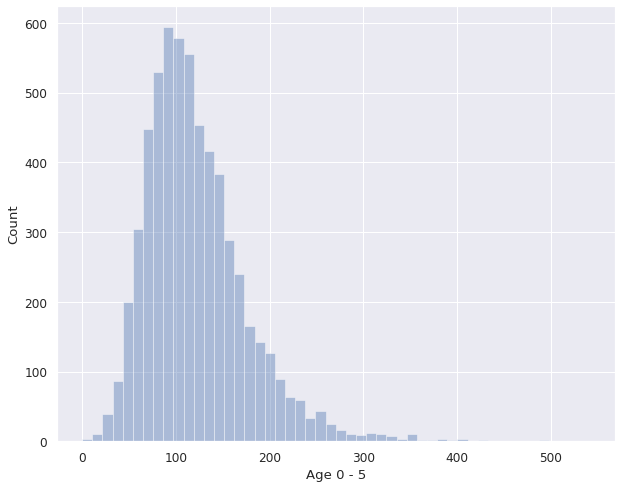

In [19]:
#getting the distribution plot
sns.set(style='darkgrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [10, 8]})
sns.distplot(population['Age0_5'], norm_hist=False, kde=False).set(xlabel='Age 0 - 5', ylabel='Count');

As you can see from the below distribution plot, it is skewed in the right with a long tail in the right.

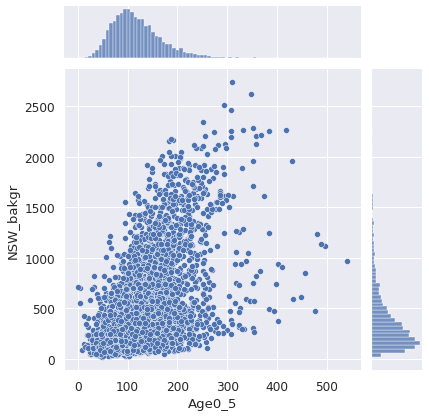

In [20]:
sns.jointplot(x=population['Age0_5'], y=population['NSW_bakgr']);

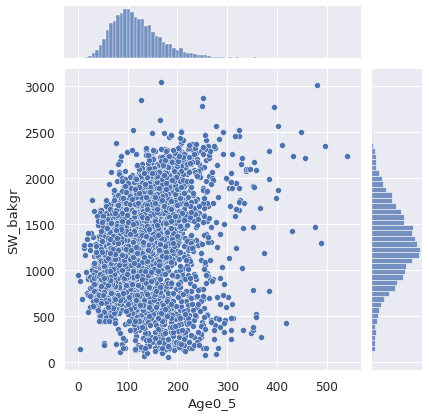

In [21]:
sns.jointplot(x=population['Age0_5'], y=population['SW_bakgr']);

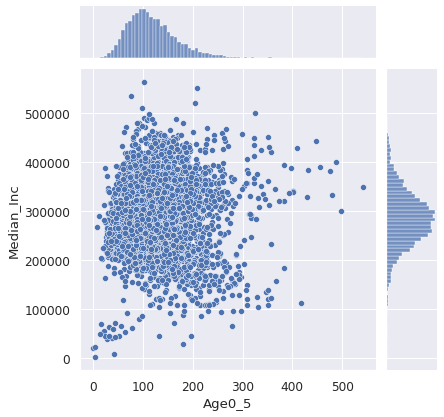

In [22]:
sns.jointplot(x=population['Age0_5'], y=population['Median_Inc']);

Since we are dealing with geographic data we can also visualize maps. In this example, we will construct a Choropleth map of the children between the ages of 0 to 5. First, we need to calculate the children density of the area by calculating Age0_5 / Tot_pop to create a new Age05_density column.

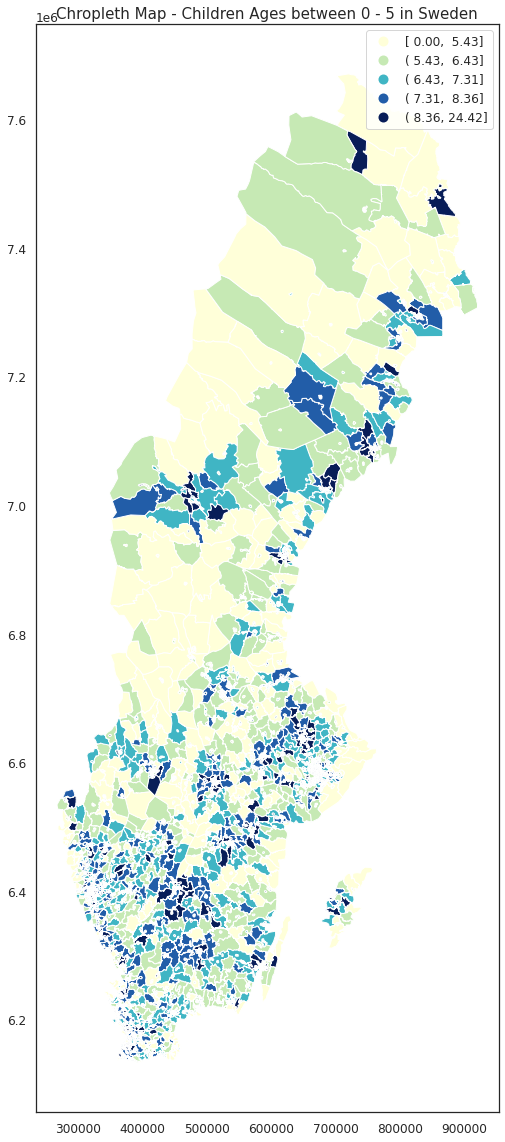

In [23]:
# setting syle
sns.set(style='white', palette="deep", font_scale=1.1, rc={"figure.figsize": [10, 8]})

#getting the density of ages 0-5
population['Age05_density'] = population['Age0_5'] / population['Tot_pop'] * 100

#plotting choropleth
fig, ax = plt.subplots(figsize=(18,16))
population.plot(column='Age05_density', scheme='Quantiles', k=5, cmap='YlGnBu', legend=True, ax=ax);
plt.tight_layout()
plt.title('Chropleth Map - Children Ages between 0 - 5 in Sweden', fontsize= 15,  y=0.5)
#plt.savefig('choroplethmap.png', bbox_inches="tight")
plt.show()

The output map indicates the number of children in each area by colour.

The map clearly shows the distribution of children in these areas. In the north, children density is very low while in the east, west and south where we have a high density of children.

Finally, let us overlay the preschools on the choropleth map and look at the distribution of schools.

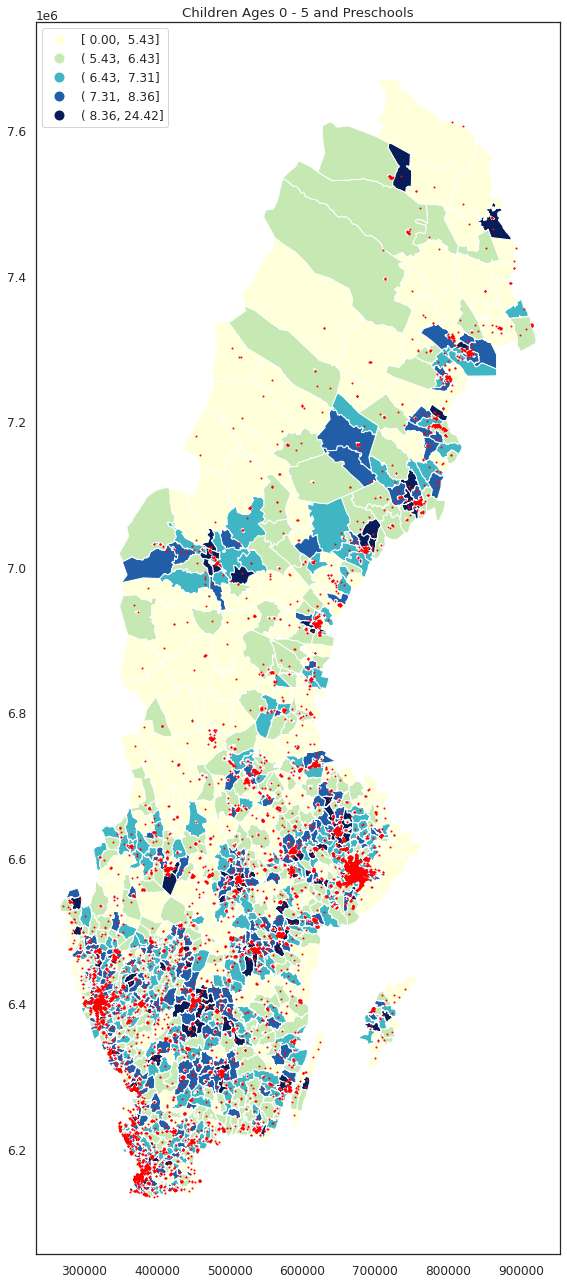

In [25]:
#plotting the overlayed preschools on the density of ages 0-5
fig, ax = plt.subplots(figsize=(22,18))

#plotting chorpleth with age 0-5 density
population.plot(column='Age05_density', scheme='Quantiles', k=5, cmap='YlGnBu', legend=True, ax=ax);

#overlaying the preschools on the choropleth
preschools.plot(ax=ax, color='red', markersize=1)

plt.tight_layout()
#ax.set_axis_off()
plt.title('Children Ages 0 - 5 and Preschools')
#plt.savefig('choroplethmap_and_preschools.png', bbox_inches="tight")
plt.show()

It is quite messy. We can not know for sure how many preschools are located in each area. This is where spatial join and geoprocessing tasks come handy. In the next section, we will perform several preprocessing tasks to get the number of preschools within each area.

In [27]:
preschools.crs, population.crs

(<Projected CRS: EPSG:3006>
 Name: SWEREF99 TM
 Axis Info [cartesian]:
 - N[north]: Northing (metre)
 - E[east]: Easting (metre)
 Area of Use:
 - name: Sweden
 - bounds: (10.03, 54.96, 24.17, 69.07)
 Coordinate Operation:
 - name: SWEREF99 TM
 - method: Transverse Mercator
 Datum: SWEREF99
 - Ellipsoid: GRS 1980
 - Prime Meridian: Greenwich, <Projected CRS: EPSG:3006>
 Name: SWEREF99 TM
 Axis Info [cartesian]:
 - N[north]: Northing (metre)
 - E[east]: Easting (metre)
 Area of Use:
 - name: Sweden
 - bounds: (10.03, 54.96, 24.17, 69.07)
 Coordinate Operation:
 - name: SWEREF99 TM
 - method: Transverse Mercator
 Datum: SWEREF99
 - Ellipsoid: GRS 1980
 - Prime Meridian: Greenwich)

**Spatial Join**

Count number of preschools within each area. The process contains the following:

1. Use spatial join to determine which preschools within the polygon area.
2. Group by size to the aggregate number of preschools in each area.
3. Merge the group by dataframe with population dataset.

In [29]:
# Points in Polygon
pop_within_schools = gpd.sjoin(population,preschools, op='contains' )
pop_within_schools.head(2)

,Deso,Age0_5,Tot_pop,SW_bakgr,NSW_bakgr,Median_Inc,U_median,O_median,HH_Child,HH_NoChild,Single_Chi,Single_NoC,Others,geometry,Age05_density,index_right,Name,FIRMABEN,Address,City,POSTORT,POSTNUMMER,POSTADRESS,KOM,KOMTEXT
1,0136A0010,37,738,640,98,284119,303,315,62,113,21,120,25,"POLYGON ((688731.626 6547758.133, 686809.834 6...",5.013550,789,HANINGE KOMMUN,MUSKÖ SKOLA OCH FÖRSKOLA,ARBOTTNAVÄGEN 1,MUSKÖ,HANINGE,13681,None,136,Haninge
2,0188A0150,71,1220,1054,166,257476,548,456,110,173,36,214,37,"POLYGON ((699545.557 6645614.544, 699264.282 6...",5.819672,4993,NORRTÄLJE KOMMUN,EDSBRO FÖRSKOLA,BROKULLAVÄGEN 2,EDSBRO,EDSBRO,76297,SKOLVÄGEN 2,188,Norrtälje


In [32]:
population.shape

(5985, 15)

In [31]:
preschools.shape

(9599, 10)

In [30]:
pop_within_schools.shape

(9599, 25)

In [33]:
# Groupby- this groups the all the schools in one area or Deso
grouped_pop = pop_within_schools.groupby('Deso').size()
grouped_pop.head()

Deso
0114C1030    3
0114C1040    1
0114C1050    4
0114C1060    1
0114C1070    1
dtype: int64

In [34]:
#checking the shape of the grouped_pop(the areas that have pre_schools)
grouped_pop.shape, population.shape

((4776,), (5985, 15))

In [35]:
# getting the deso or areas with no preschools
population.shape[0] - grouped_pop.shape[0]

1209

In [36]:
# Create datafrom from grouped_pop
df = grouped_pop.to_frame().reset_index()
df.columns = ['Deso', 'preschool_count']
df.head()

,Deso,preschool_count
0,0114C1030,3
1,0114C1040,1
2,0114C1050,4
3,0114C1060,1
4,0114C1070,1


In [38]:
# Merge df and population: outer join to include other dropped rows from grouped_pop
merged_population = population.merge(df, on='Deso', how='outer')
merged_population.head(2)

,Deso,Age0_5,Tot_pop,SW_bakgr,NSW_bakgr,Median_Inc,U_median,O_median,HH_Child,HH_NoChild,Single_Chi,Single_NoC,Others,geometry,Age05_density,preschool_count
0,0115A0040,113,1443,1180,263,306746,480,615,187,126,50,121,58,"POLYGON ((690301.503 6614909.754, 690301.470 6...",7.830908,NaN
1,0136A0010,37,738,640,98,284119,303,315,62,113,21,120,25,"POLYGON ((688731.626 6547758.133, 686809.834 6...",5.013550,1.0


In [39]:
# Merged_population has the original population size
merged_population.shape

(5985, 16)

In [40]:
# Those areas with no preschools have NaN values. Fill it with 0
merged_population['preschool_count'].fillna(0,inplace=True)
merged_population['preschool_count'] = merged_population['preschool_count'].astype(int)

In [41]:
merged_population.head(2)

,Deso,Age0_5,Tot_pop,SW_bakgr,NSW_bakgr,Median_Inc,U_median,O_median,HH_Child,HH_NoChild,Single_Chi,Single_NoC,Others,geometry,Age05_density,preschool_count
0,0115A0040,113,1443,1180,263,306746,480,615,187,126,50,121,58,"POLYGON ((690301.503 6614909.754, 690301.470 6...",7.830908,0
1,0136A0010,37,738,640,98,284119,303,315,62,113,21,120,25,"POLYGON ((688731.626 6547758.133, 686809.834 6...",5.013550,1


In [43]:
columns = ['Deso',	'Age0_5', 'Tot_pop', 'SW_bakgr',
            'NSW_bakgr', 'Median_Inc', 	'U_median',	
            'O_median','HH_Child',	'HH_NoChild',	
            'Single_Chi',	'Single_NoC',	'Others', 'Age05_density', 'preschool_count','geometry']

merged_population[columns].head(2)

,Deso,Age0_5,Tot_pop,SW_bakgr,NSW_bakgr,Median_Inc,U_median,O_median,HH_Child,HH_NoChild,Single_Chi,Single_NoC,Others,Age05_density,preschool_count,geometry
0,0115A0040,113,1443,1180,263,306746,480,615,187,126,50,121,58,7.830908,0,"POLYGON ((690301.503 6614909.754, 690301.470 6..."
1,0136A0010,37,738,640,98,284119,303,315,62,113,21,120,25,5.013550,1,"POLYGON ((688731.626 6547758.133, 686809.834 6..."


In [44]:
#statistics on the preschools
merged_population.preschool_count.describe()

count    5985.000000
mean        1.603843
std         1.333176
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: preschool_count, dtype: float64

Now we can examine side by side choropleth maps of age density as well as a new choropleth map based on the preschool count.

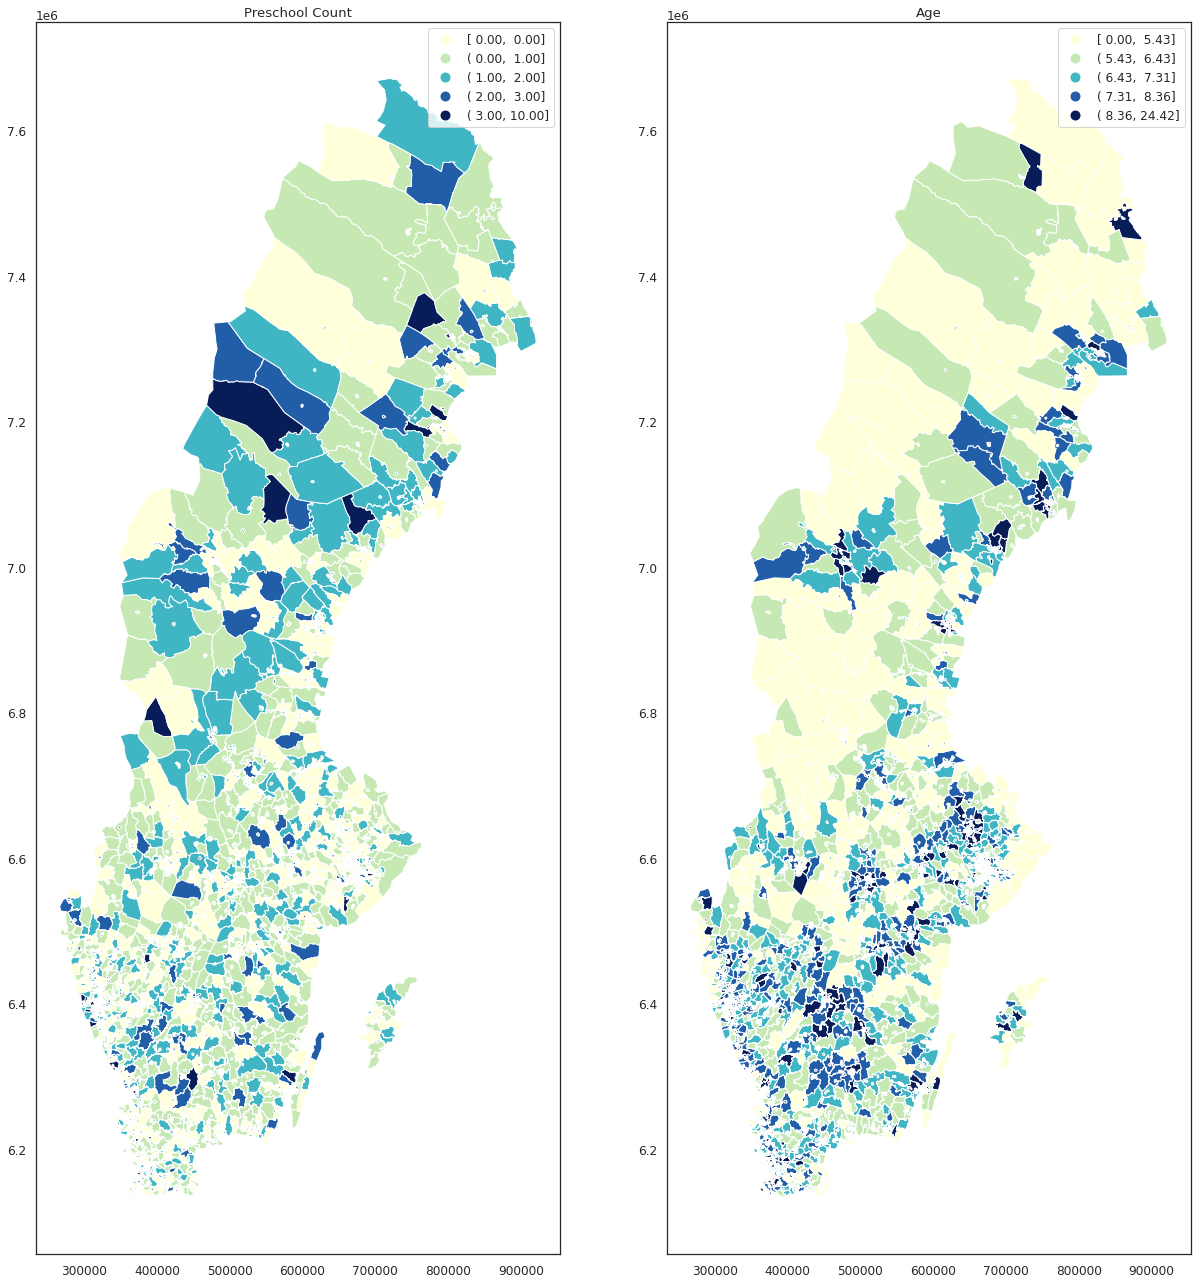

In [45]:
fig, ax = plt.subplots(1,2, figsize=(18,18))
merged_population.plot(column='preschool_count', scheme='Quantiles', k=5, cmap='YlGnBu', legend=True, ax=ax[0]);
merged_population.plot(column='Age05_density', scheme='Quantiles', k=5, cmap='YlGnBu', legend=True, ax=ax[1]);
plt.tight_layout()
ax[0].set_title("Preschool Count")
ax[1].set_title("Age")
#plt.savefig('comparison.png', bbox_inches="tight")
plt.show()

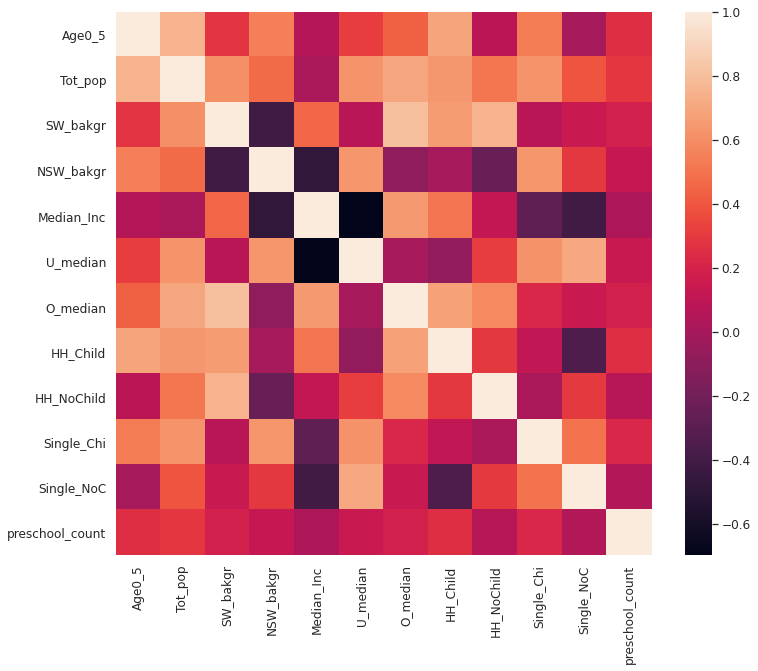

In [46]:
# Visualizing the correlation using a heatmap
columns = ['Age0_5', 'Tot_pop','SW_bakgr', 'NSW_bakgr', 'Median_Inc', 
           'U_median','O_median', 'HH_Child', 'HH_NoChild', 
           'Single_Chi', 'Single_NoC',  'preschool_count']

# calculate correlation matrix
correlation = merged_population[columns].corr()

fig, ax = plt.subplots(figsize=(12,10))
# plot the heatmap
sns.heatmap(correlation, xticklabels=columns,yticklabels=columns, ax=ax)
plt.show()

However, we can not have a meaningful comparison of these two completely different features. As you can preschool_counts are in the range of 0 –10 while the age_density varies between 0 to 24. In statistics, like the EDA we performed earlier, we assume independence among observations in the dataset, however, with Geographic dataset, there is a strong spatial dependency

### Exploratory Spatial Data Analysis(ESDA)

Spatial statistics and Exploratory Spatial Data Analysis (ESDA) is very broad. In this section, we will only look at the Local Indicator of Spatial Association (LISA) to detect spatial autocorrelation in this dataset and explore characteristics of close locations and their correlations. This can help us to study and understand the spatial distribution and structure as well as detecting spatial autocorrelation in this data.

To get a closer look at these spatial statistics, we first read counties dataset, subset our data to the most two populated cities in Sweden, Stockholm and Gothenburg and then merge with our preprocessed population dataset.

In [58]:
#reading the counties dataset
counties = gpd.read_file("dataset/ak_riks.shp")
counties.head(2)

,KOMMUNNAMN,KKOD,KATEGORI,LANSNAMN,KOMMUNKOD,LANSKOD,KOM_KOD,LAN_KOD,ADAT,geometry
0,Emmaboda,414,Kommun,Kalmar län,862,8,0862,08,None,"POLYGON ((525639.084 6277407.250, 525609.911 6..."
1,Vännäs,414,Kommun,Västerbottens län,2460,24,2460,24,1912-12-12 12:00,"POLYGON ((733523.723 7115267.096, 737073.363 7..."


In [59]:
# Subset two cities
stockholm = counties[counties['KOMMUNNAMN'] == 'Stockholm']
gothenburg = counties[counties['KOMMUNNAMN'] == 'Göteborg']

In [60]:
# Spatial join two cities with population dataset
stockholm_pop = gpd.sjoin(merged_population,stockholm, op='within' )
gothenburg_pop = gpd.sjoin(merged_population,gothenburg, op='within' )

We will use Pysal and Splot libraries to carry out spatial autocorrelation. This is the setup and transformation of weights. We take preschool_count as our y variable and perform Queen weights transformation. We then create a spatial lag column (y_lag) using the weights to get similarity of different polygons based on their geographic areas.

In [61]:
#Create y variable values for stockholm
ys = stockholm_pop['preschool_count'].values

# Get Weights (Queen)
wqs = Queen.from_dataframe(stockholm_pop)
wqs.transform = 'r'

# Sptial lag
ylags = weights.lag_spatial(wqs, ys)
stockholm_pop['ylag'] = ylags

('WARNING: ', 13, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 87, ' is an island (no neighbors)')
('WARNING: ', 165, ' is an island (no neighbors)')


/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 13, 14, 87, 165.



In [56]:
# Create y variable values for gothenburg
yg = gothenburg_pop['preschool_count'].values

# Get Weights (Queen)
wqg = Queen.from_dataframe(gothenburg_pop)
wqg.transform = 'r'

# Sptial lag
ylagg = weights.lag_spatial(wqg, yg)
gothenburg_pop['ylag'] = ylagg

('WARNING: ', 246, ' is an island (no neighbors)')
('WARNING: ', 253, ' is an island (no neighbors)')


/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 246, 253.



Now we can calculate Moran’s I local to detect clusters and outliers.

In [57]:
# calculate Moran_Local and plot
moran_loc_s = Moran_Local(ys, wqs)
moran_loc_g = Moran_Local(yg, wqg)

ValueError: ignored